<a href="https://colab.research.google.com/github/AryamanKaprekar/Practice_Collection/blob/main/using_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resnet-18 for Detecting MRI anamolies in Brain using Brain MRI dataset from Kaggle**

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import requests
import kagglehub
import zipfile
from pathlib import Path
import os
import shutil
from sklearn.model_selection import train_test_split
print(torch.__version__)
print(torchvision.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# Download dataset using kagglehub
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print(f"Path to dataset: {path}")

# Define paths for training and test sets
train_path = "/content/train"
test_path = "/content/test"

# Check if train and test sets already exist
if os.path.exists(train_path) and os.path.exists(test_path):
    print("Train and test sets already exist.")
else:
    # Create directories for training and testing sets
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Split each classification into training and test sets
    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)

        # Skip if not a directory
        if not os.path.isdir(class_dir):
            continue

        # List all images in the class directory
        images = os.listdir(class_dir)

        # Split into training and testing sets
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Create subdirectories for the class in train and test folders
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Move training images
        for image in train_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(train_path, class_name, image))

        # Move testing images
        for image in test_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(test_path, class_name, image))

    print("Dataset successfully divided into training and test sets!")

2.5.0+cu121
0.20.0+cu121
Using device: cuda


100%|██████████| 236M/236M [00:13<00:00, 17.7MB/s]

Extracting files...


Path to dataset: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1
Dataset successfully divided into training and test sets!


In [ ]:
transform= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data=datasets.ImageFolder(root=train_path, transform=transform)
test_data=datasets.ImageFolder(root=test_path, transform=transform)
print(len(train_data),len(test_data))
print(train_data.class_to_idx)
print(test_data.class_to_idx)
train_dataloader=torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

5617 1406
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}


In [ ]:
model=resnet18(weights=True)
model.fc=nn.Linear(in_features=512, out_features=4)
model=model.to(device)
optimizer=torch.optim.Adam(params=model.parameters(), lr=3e-4, weight_decay=0.0001)
loss_fn=nn.CrossEntropyLoss()
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc=0,0
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred=model(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
    train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):
  model.eval()
  test_loss, test_acc=0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits=model(X)
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)
  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn=nn.CrossEntropyLoss(),
          epochs:int=5):
  results={"train_loss":[],
          "train_acc":[],
          "test_loss":[],
          "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer)
    test_loss, test_acc=test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [ ]:
from timeit import default_timer as timer
start_time=timer()
results=train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=5)
end_time=timer()
print(f"Total training time {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.0003 | Train Acc: 0.9162 | Test Loss: 0.2238 | Test Acc: 0.9261
Epoch: 1 | Train Loss: 0.0001 | Train Acc: 0.9654 | Test Loss: 0.1023 | Test Acc: 0.9630
Epoch: 2 | Train Loss: 0.0006 | Train Acc: 0.9782 | Test Loss: 0.0783 | Test Acc: 0.9666
Epoch: 3 | Train Loss: 0.0011 | Train Acc: 0.9844 | Test Loss: 0.0723 | Test Acc: 0.9716
Epoch: 4 | Train Loss: 0.0005 | Train Acc: 0.9828 | Test Loss: 0.0651 | Test Acc: 0.9771
Total training time 248.172 seconds


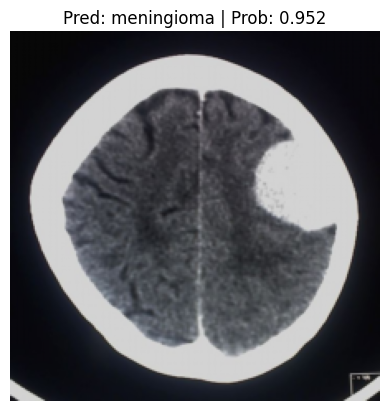

In [ ]:
custom_image_path="/content/testing.png"
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(224,224))
])
def pred_and_plot_image(model:torch.nn.Module,
                         image_path:str,
                         class_names:list[str]=None,
                         transform=None,
                         device=device):
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)/255.0
  if transform:
    target_image=transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred=model(target_image.unsqueeze(0).to(device))
  target_image_pred_prob=torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_pred_prob, dim=1)
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title=f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max():.3f}"
  else:
    title=f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max():.3f}"
  plt.title(title)
  plt.axis(False)
pred_and_plot_image(model=model,
                  image_path=custom_image_path,
                  class_names=train_data.classes,
                  transform=custom_image_transform,
                  device=device)